In [1]:
import numpy as np
import pandas as pd
import vectorbtpro as vbt

In [2]:
vbt.settings.portfolio["signal_direction"] = "both"
vbt.settings.wrapping["freq"] = "daily"

In [3]:
price = vbt.YFData.fetch('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2022-11-11 00:00:00+00:00    17034.292969
2022-11-12 00:00:00+00:00    16799.185547
2022-11-13 00:00:00+00:00    16353.365234
2022-11-14 00:00:00+00:00    16618.199219
2022-11-15 00:00:00+00:00    16812.730469
Freq: D, Name: Close, Length: 2982, dtype: float64


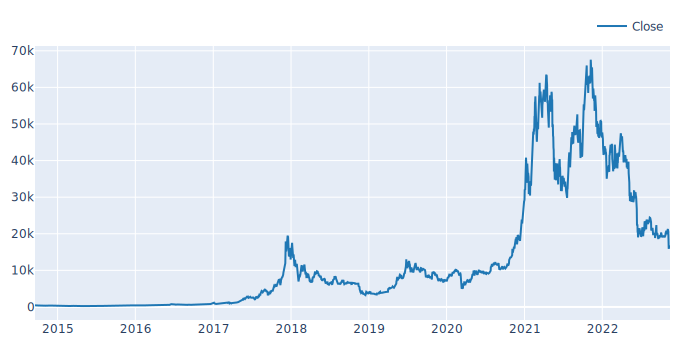

In [5]:
price.vbt.plot().show_svg()

In [6]:
# 30 windows, each 2 years long, reserve half of that for test
splitter = vbt.Splitter.from_n_rolling(
    price.index,
    n=30, 
    length=365 * 2, 
    split=0.5,
    set_labels=['in-sample', 'out-sample']
)

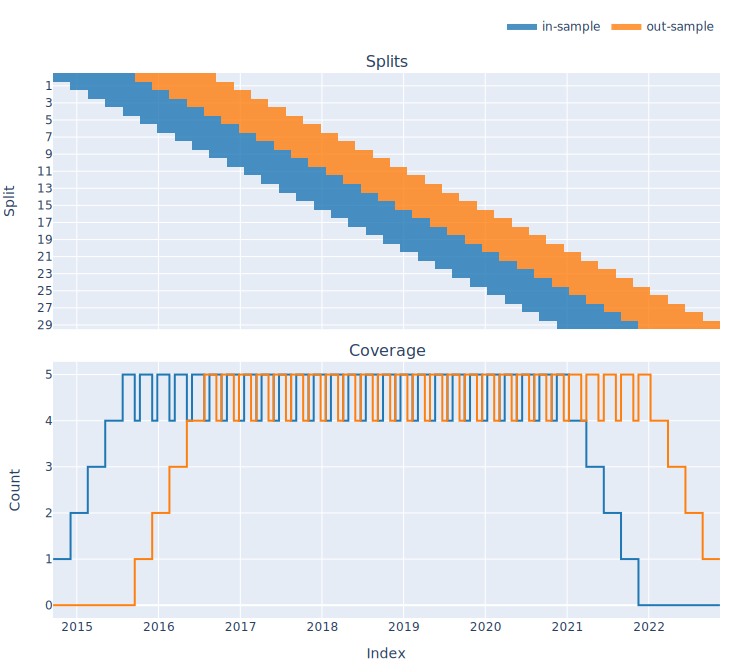

In [7]:
splitter.plots().show_svg()

In [8]:
split_price = splitter.take(price, into="reset_stacked_splits")
split_index = splitter.take(price.index)
in_price = split_price[0]
out_price = split_price[1]

print(in_price.shape)  # in-sample
print(out_price.shape)  # out-sample

(365, 30)
(365, 30)


In [9]:
in_hold_sharpe = vbt.Portfolio.from_holding(in_price).sharpe_ratio
out_hold_sharpe = vbt.Portfolio.from_holding(out_price).sharpe_ratio

print(pd.concat((in_hold_sharpe, out_hold_sharpe), axis=1, keys=splitter.set_labels))

set    in-sample  out-sample
split                       
0      -0.658458    2.001694
1       0.312138    1.773579
2       1.268443    2.065583
3       1.451948    2.453768
4       1.669052    2.464135
5       1.927219    2.972812
6       1.810779    3.416174
7       2.361321    2.432264
8       2.706870    1.692574
9       3.217886    0.859991
10      3.169262    0.334711
11      3.121554   -1.088238
12      2.194916   -0.121605
13      1.276207    1.183197
14      0.919373    1.090327
15     -0.449631    1.137570
16     -0.871426    1.818362
17     -0.665786    0.915454
18      1.033010    0.357266
19      0.678428    0.750919
20      1.187676    1.896918
21      1.519990    2.500559
22      0.696131    2.492773
23      0.367942    2.078531
24      0.952972    2.309961
25      2.597111    0.439856
26      3.598004    0.126844
27      2.300341   -0.501108
28      2.217836   -0.911591
29      2.057923   -1.587346


In [10]:
def simulate_all_params(price, windows):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits)
    return pf.sharpe_ratio

In [12]:
# Simulate all params for in-sample ranges
windows = np.arange(10, 50)
in_sharpe = simulate_all_params(in_price, windows)

print(in_sharpe)

fast_window  slow_window  split
10           11           0        0.014543
                          1        0.891812
                          2        1.118409
                          3        1.524072
                          4        0.686637
                                     ...   
48           49           25      -0.480365
                          26       1.746214
                          27       1.542524
                          28       2.182004
                          29      -0.735457
Name: sharpe_ratio, Length: 23400, dtype: float64


In [13]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split').idxmax()].index
    return performance[performance.groupby('split').idxmin()].index

In [14]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (23, 25,  2),
            (28, 29,  3),
            (23, 25,  4),
            (23, 25,  5),
            (37, 44,  6),
            (37, 43,  7),
            (10, 21,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 22, 11),
            (10, 22, 12),
            (10, 22, 13),
            (10, 21, 14),
            (17, 22, 15),
            (13, 21, 16),
            (18, 20, 17),
            (42, 43, 18),
            (47, 49, 19),
            (39, 48, 20),
            (18, 21, 21),
            (11, 22, 22),
            (18, 20, 23),
            (16, 17, 24),
            (14, 21, 25),
            (45, 46, 26),
            (31, 36, 27),
            (33, 35, 28),
            (29, 30, 29)],
           names=['fast_window', 'slow_window', 'split'])


In [15]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [16]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [23 25]
 [28 29]
 [23 25]
 [23 25]
 [37 44]
 [37 43]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [10 21]
 [17 22]
 [13 21]
 [18 20]
 [42 43]
 [47 49]
 [39 48]
 [18 21]
 [11 22]
 [18 20]
 [16 17]
 [14 21]
 [45 46]
 [31 36]
 [33 35]
 [29 30]]


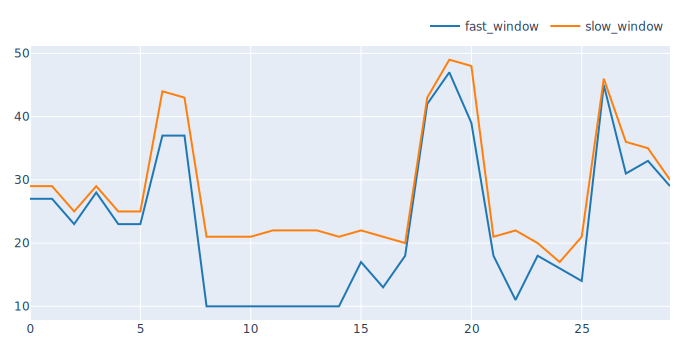

In [17]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [18]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows)

print(out_sharpe)

fast_window  slow_window  split
10           11           0        0.704344
                          1       -0.156280
                          2       -0.609579
                          3        0.531782
                          4        0.907786
                                     ...   
48           49           25      -0.455214
                          26       0.604113
                          27       0.127640
                          28       0.219396
                          29      -0.760904
Name: sharpe_ratio, Length: 23400, dtype: float64


In [19]:
def simulate_best_params(price, best_fast_windows, best_slow_windows):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits)
    return pf.sharpe_ratio

In [20]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows)

print(out_test_sharpe)

ma_window  ma_window  split
27         29         0        1.011346
                      1        1.565815
23         25         2        1.528176
28         29         3        0.089220
23         25         4        1.086632
                      5        0.808206
37         44         6        0.739280
           43         7        0.493354
10         21         8        2.880501
                      9        2.556133
                      10       0.757051
           22         11       0.765008
                      12       1.461918
                      13       1.582765
           21         14       0.758591
17         22         15       1.355770
13         21         16       2.094523
18         20         17       1.133328
42         43         18      -0.997163
47         49         19      -1.442581
39         48         20       0.369739
18         21         21       1.409519
11         22         22       1.571074
18         20         23       0.576421
16         1

In [21]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split').median().values,
    'out_sample_test': out_test_sharpe.values
})

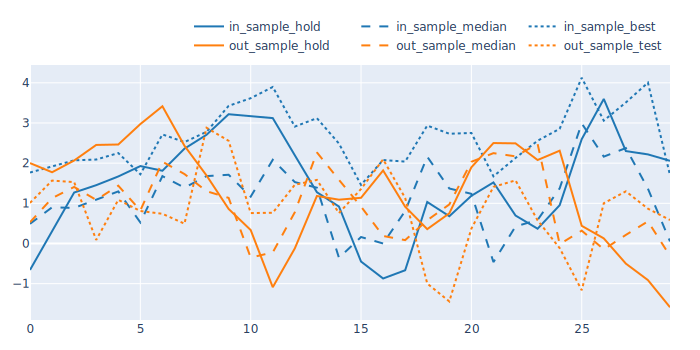

In [24]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()